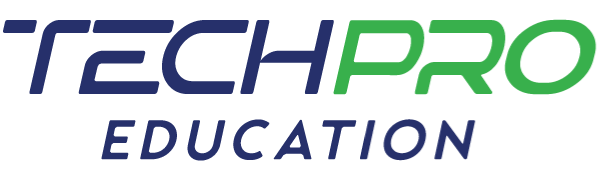

# Hierarchical Clustering

**Genel cluster mantığı**: cluster içindeki gözlemler arasında minmum mesafe, kümeler arası max mesafe.. Küme içinde sıkı sıkıya tutnma, diğer clusterdan mümkün ldukça kaçınma. ana prensip bu. 

**K-Means den farklı olarak herhangi bir model tanımlaması yapmadan önce dendrogram oluşturarak işe başlayacağız.Kmeans de default değerlerleolsa bile bir model tanımlaması yapıp o şekilde başlamıştık.**

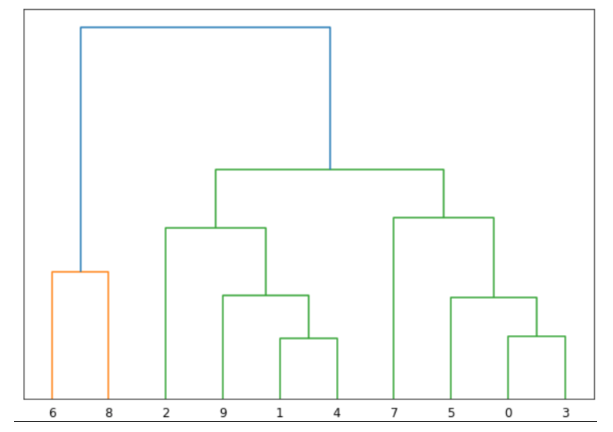

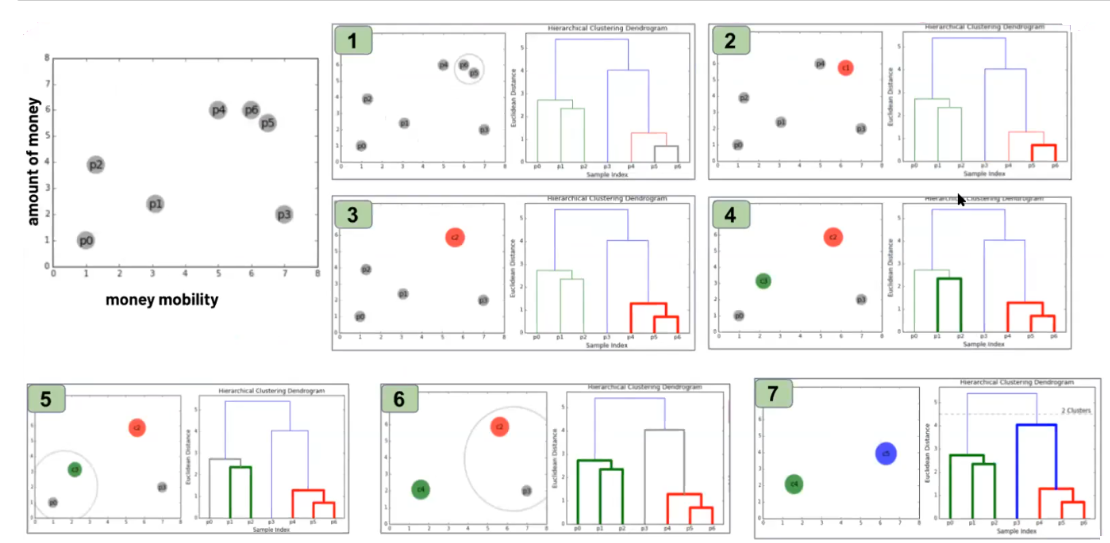

Hiyerarşik kümeleme iki ana yaklaşıma ayrılır:

Agglomerative (Birleştirici) Yaklaşım: Bu yöntemde, her veri noktası başlangıçta kendi başına bir küme olarak kabul edilir. Daha sonra benzerliklerine göre adım adım birleştirilirler. Bu süreç, tüm veri noktaları tek bir kümede toplanana kadar devam eder. Benzerlik ölçümleri genellikle uzaklık metrikleri (örneğin, Öklid uzaklığı) ile yapılır.

Divisive (Bölücü) Yaklaşım: Bu yaklaşımda, tüm veri noktaları başlangıçta tek bir büyük küme olarak ele alınır. Daha sonra bu büyük küme, daha küçük kümeler halinde bölünmeye başlar. Bu süreç, her veri noktası kendi başına bir küme haline gelene kadar veya belirli bir kriter sağlanana kadar devam eder.

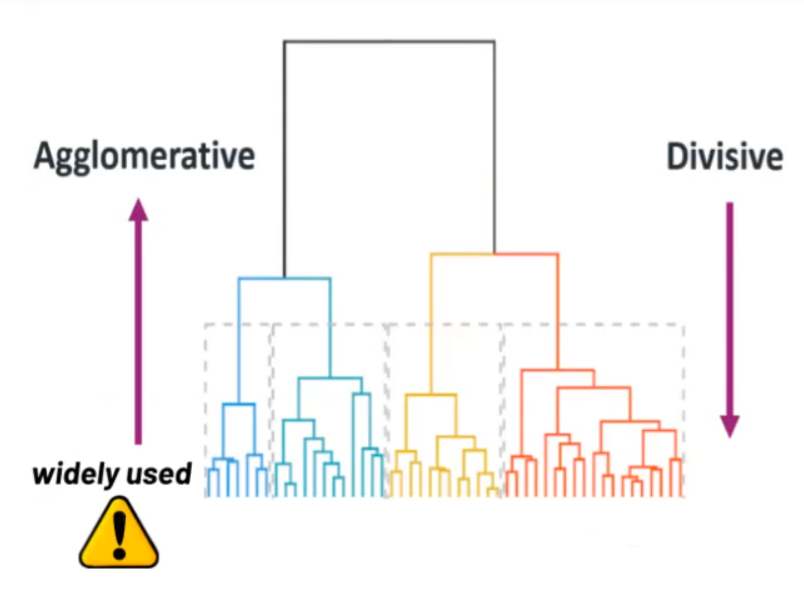

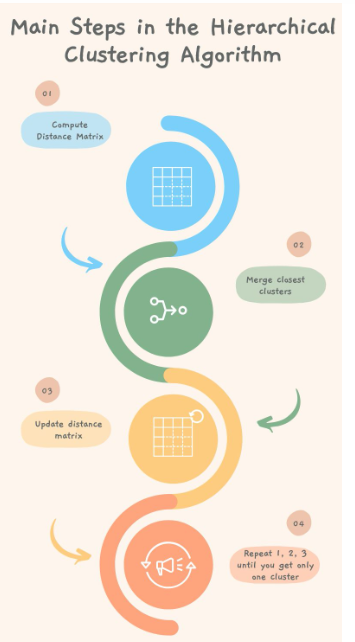

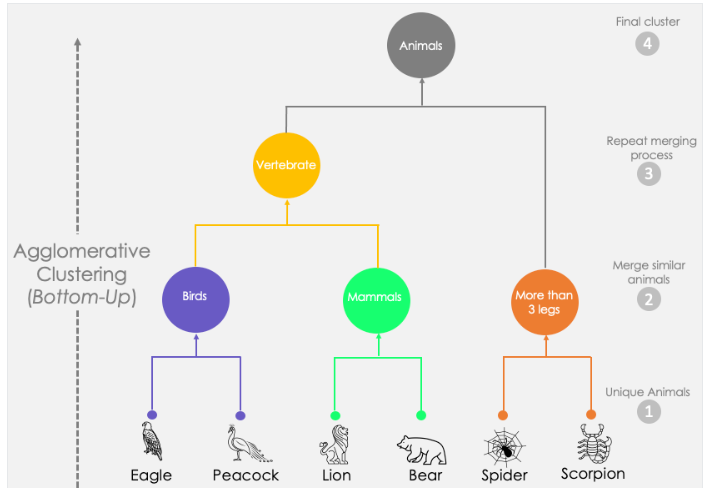

### Dendrogram nasıl okunur?

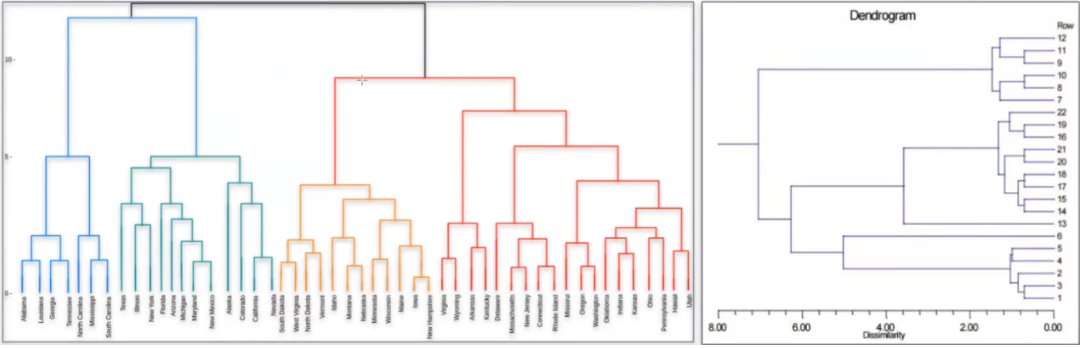

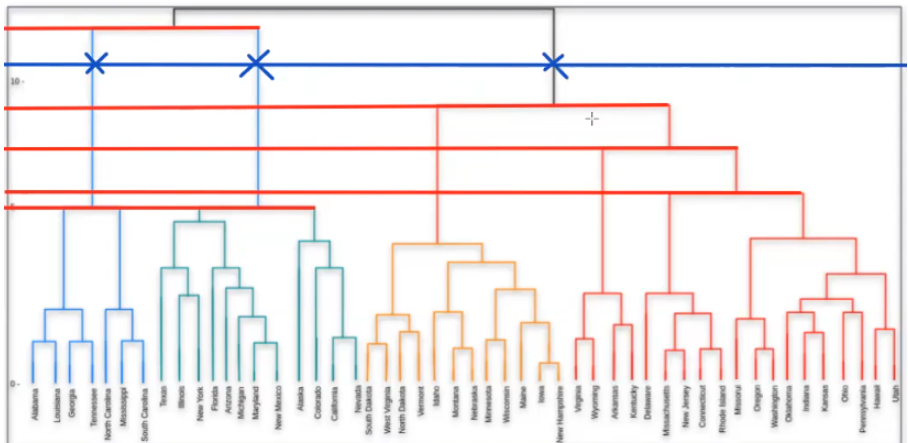

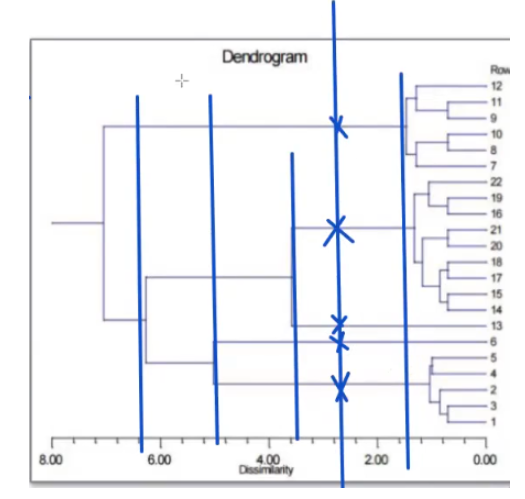

- ayrismalardan cizgi cekilir
- en genis aralik bulunur
- en genis araligin ortasindan cizgi cekildiginde kac cizgiyi kesiyorsa cluster sayisi ona gore secilir

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

#çizimleri notebookta açmak için
%matplotlib inline                        
#%matplotlib notebook                     #çizimlere zoom yapmak için
plt.rcParams["figure.figsize"] = (10,6)   # çizimlerin standart boyutu
import warnings                           # uyarı mesajlarını kontrol için
warnings.filterwarnings("ignore")         # istenmeyen gereksiz mesajları göstermez
warnings.warn("this will not show")
#pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [2]:
df = pd.read_csv("iris_1.csv")     # iris dosyasının "species" feature olmayan hali

In [3]:
df.head()

,sepal_length,sepal_width,petal_length,petal_width
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


## Exploratory Data Analysis and Visualization

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   sepal_length  150 non-null    float64
 1   sepal_width   150 non-null    float64
 2   petal_length  150 non-null    float64
 3   petal_width   150 non-null    float64
dtypes: float64(4)
memory usage: 4.8 KB


In [5]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
sepal_length,150.0,5.843333,0.828066,4.3,5.1,5.80,6.4,7.9
sepal_width,150.0,3.057333,0.435866,2.0,2.8,3.00,3.3,4.4
petal_length,150.0,3.758000,1.765298,1.0,1.6,4.35,5.1,6.9
petal_width,150.0,1.199333,0.762238,0.1,0.3,1.30,1.8,2.5


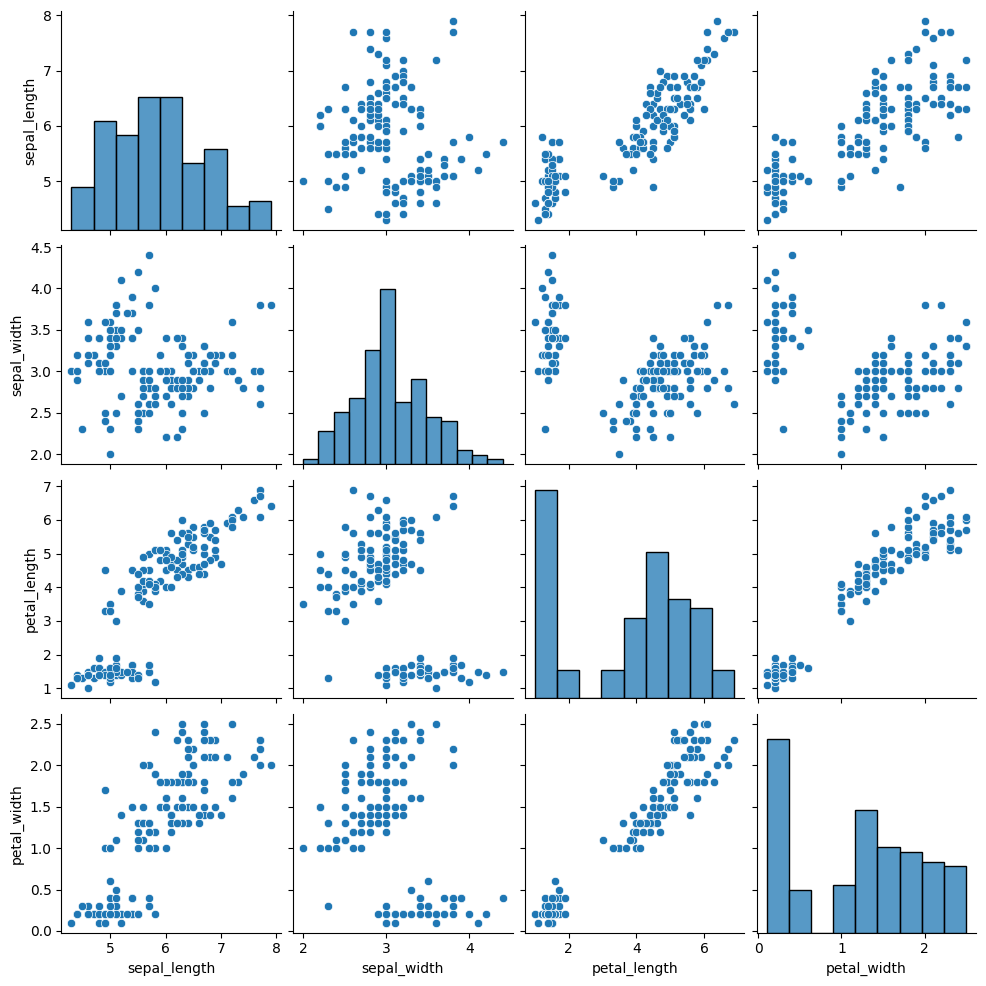

In [6]:
sns.pairplot(df);

## Scaling Data

Scale konusunda: Hiyerarşik kümelemede ölçeklendirme (scale) yapılması genellikle önemlidir, özellikle değişkenleriniz arasında büyük ölçek farklılıkları varsa.

Irıs data setinde scale yapmadan devam ediyoruz. Iris veri setindeki tüm özellikler santimetre cinsinden ölçülür, bu nedenle bu özellikler zaten benzer ölçeklerde olduğu için ölçeklendirme yapmak genellikle gerekli değildir. 

alttaki resimde farklı scale durumlarınnı sonuçları görünüyor.

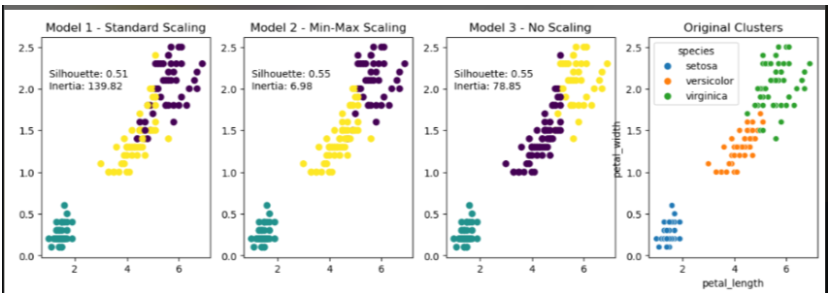

Alt tarafta biz scale edilmemiş haliyle devam edeceğiz

## Hopkins Test

Özetle, Hopkins testi, bir veri kümesinin düzgün bir dağılım gösterip göstermediğini ve bu bağlamda kümelemenin uygun olup olmadığını değerlendirmenizi sağlar.
Kümeleme içn 0.5 den düşük olması kabul edilebiir, ama 0.3 ve altı olması daha çok beklenen bir değerdir. 

In [7]:
# pip install scikit-learn

In [8]:
from sklearn.neighbors import BallTree
import numpy as np
import pandas as pd
def hopkins(data_frame, sampling_size):
    """Assess the clusterability of a dataset. A score between 0 and 1, a score around 0.5 express
    no clusterability and a score tending to 0 express a high cluster tendency.
    Parameters
    ----------
    data_frame : numpy array
        The input dataset
    sampling_size : int
        The sampling size which is used to evaluate the number of DataFrame.
    Returns
    ---------------------
    score : float
        The hopkins score of the dataset (between 0 and 1)
    Examples
    --------
    >>> from sklearn import datasets
    >>> from pyclustertend import hopkins
    >>> X = datasets.load_iris().data
    >>> hopkins(X,150)
    0.16
    """
    if type(data_frame) == np.ndarray:
        data_frame = pd.DataFrame(data_frame)
    # Sample n observations from D : P
    if sampling_size > data_frame.shape[0]:
        raise Exception(
            'The number of sample of sample is bigger than the shape of D')
    data_frame_sample = data_frame.sample(n=sampling_size)
    # Get the distance to their neirest neighbors in D : X
    tree = BallTree(data_frame, leaf_size=2)
    dist, _ = tree.query(data_frame_sample, k=2)
    data_frame_sample_distances_to_nearest_neighbours = dist[:, 1]
    # Randomly simulate n points with the same variation as in D : Q.
    max_data_frame = data_frame.max()
    min_data_frame = data_frame.min()
    uniformly_selected_values_0 = np.random.uniform(min_data_frame[0], max_data_frame[0], sampling_size)
    uniformly_selected_values_1 = np.random.uniform(min_data_frame[1], max_data_frame[1], sampling_size)
    uniformly_selected_observations = np.column_stack((uniformly_selected_values_0, uniformly_selected_values_1))
    if len(max_data_frame) >= 2:
        for i in range(2, len(max_data_frame)):
            uniformly_selected_values_i = np.random.uniform(min_data_frame[i], max_data_frame[i], sampling_size)
            to_stack = (uniformly_selected_observations, uniformly_selected_values_i)
            uniformly_selected_observations = np.column_stack(to_stack)
    uniformly_selected_observations_df = pd.DataFrame(uniformly_selected_observations)
    # Get the distance to their neirest neighbors in D : Y
    tree = BallTree(data_frame, leaf_size=2)
    dist, _ = tree.query(uniformly_selected_observations_df, k=1)
    uniformly_df_distances_to_nearest_neighbours = dist
    # return the hopkins score
    x = sum(data_frame_sample_distances_to_nearest_neighbours)
    y = sum(uniformly_df_distances_to_nearest_neighbours)
    if x + y == 0:
        raise Exception('The denominator of the hopkins statistics is null')
    return x / (x + y)[0]

# normalde bu fonksiyonumuz pyclustertend'ın hopkins kütüphanesinde var. Ancak oluşabilecek hatalara karşı 
# doğrudan fonksiyonun kendisini kullanacağız. Bundan dolayı pyclustertend'ı install etmemize gerek yoktur!

In [9]:
X=df.copy()

In [10]:
hopkins(X, X.shape[0])

0.17063179698425662

hopkins skoru 0.3 den küçük olduğu için clustering e uygundur

## Dendrogram

K means dan farklı olarak;  herhangi br model kurmadan ideal kümeleme sayımızı dendrogram ile görebliyoruz Yaklaşım olarak tümevarım veya tümdengelim şeklinde yapılır. 

In [11]:
from scipy.cluster.hierarchy import dendrogram, linkage

linkage fonksiyonu cluster oluşturmak için, dendrogram ise grafiği çizmek için kullanılır

**“linkage” parameter: (default= “ward”)**

  {‘ward’, ‘complete’, ‘average’, ‘single’}

Hangi bağlantı kriterinin kullanılacağı. Bağlantı kriteri, gözlem kümeleri arasında hangi mesafenin kullanılacağını belirler. 
- Ward, birleştirilen kümelerin varyansını en aza indirir.
- Average, iki kümenin her bir gözleminin uzaklıklarının ortalamasını kullanır.
- Complete veya maksimum bağlantı, iki kümenin tüm gözlemleri arasındaki maksimum mesafeleri kullanır.
- Single, iki kümenin tüm gözlemleri arasındaki mesafelerin minimumunu kullanır.

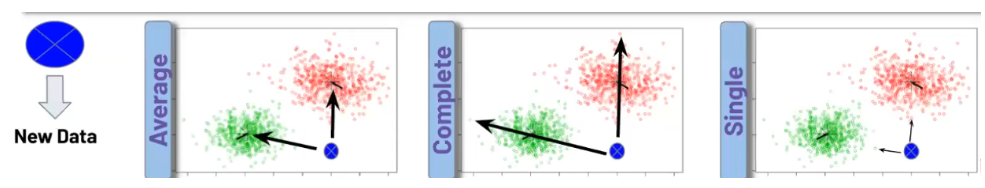

In [13]:
# dendrogram()   # Dendrogram çizimini erçekleştirek için kullanılabilecek özellikleri verir

In [14]:
hc_ward = linkage (y= X, method ="ward") #varyansa göre - mevcut kümelenmede varyansı daha az değiştireceği yere atayacak biçimde yapar
hc_complete = linkage (X, "complete") #en uzak noktaya göre - yeni noktayı mecvut kümeler içindeki en uzak noktalara göre ölçüp daha yakın olana atama yapar
hc_average = linkage (X, "average") #ortalamaya göre - tüm kümelerin uzaklık ort. alıp yeni noktaya uzaklığı ölçer
hc_single= linkage(X ,"single") #en yakın noktaya göre-  yeni nokta, mevcut kümeler içindeki en yakın noktalara mesafe alıp daha küçük mesafe olan kümeye atar

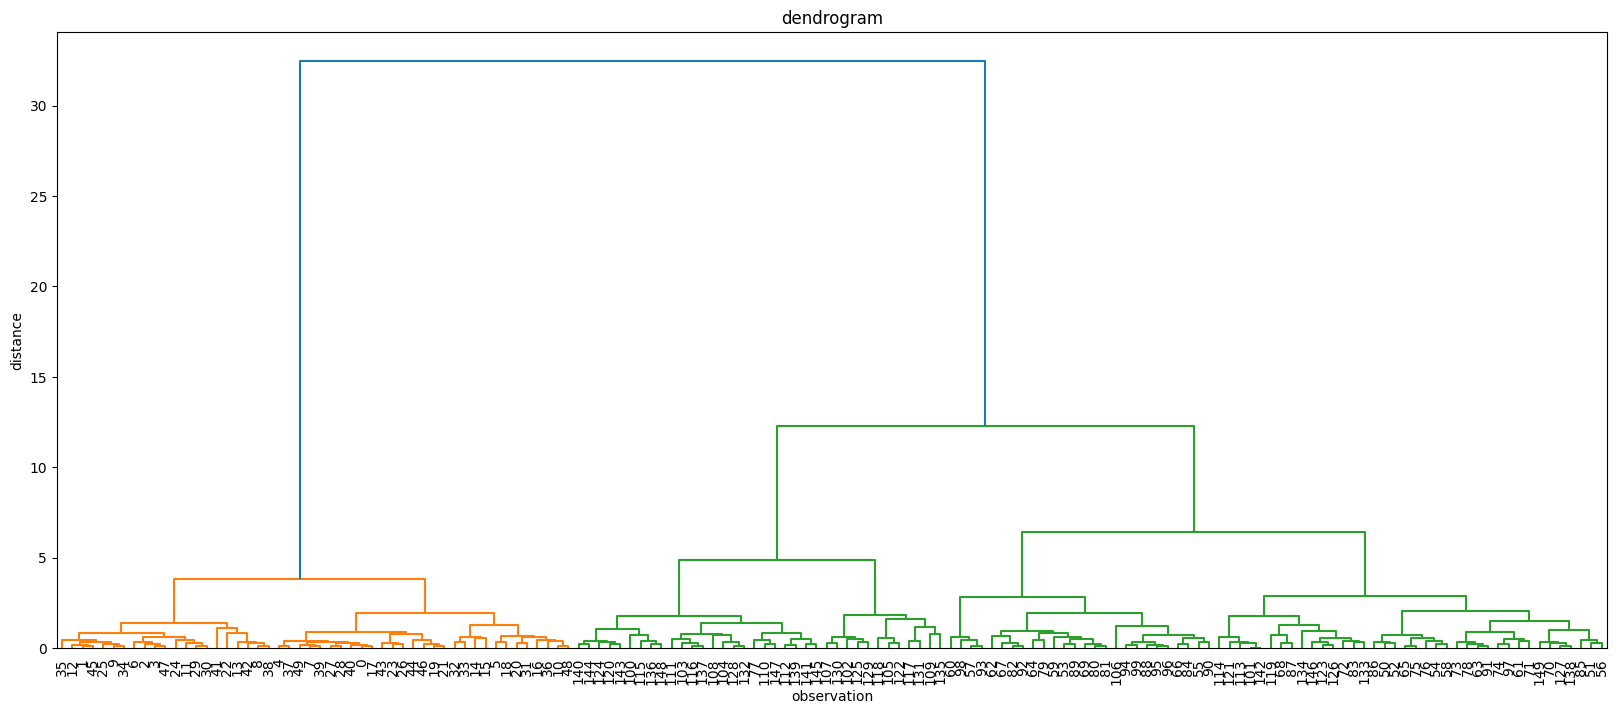

In [15]:
# dendrogram çizimini üstteki linkage hesaplamasına göre yapalım

plt.figure(figsize= (20,8))
plt.title("dendrogram")
plt.xlabel("observation")
plt.ylabel("distance")
dendrogram (hc_ward, leaf_font_size=10);  # yukardaki seçeneklerden ward a gore dendrogram yapıyorum

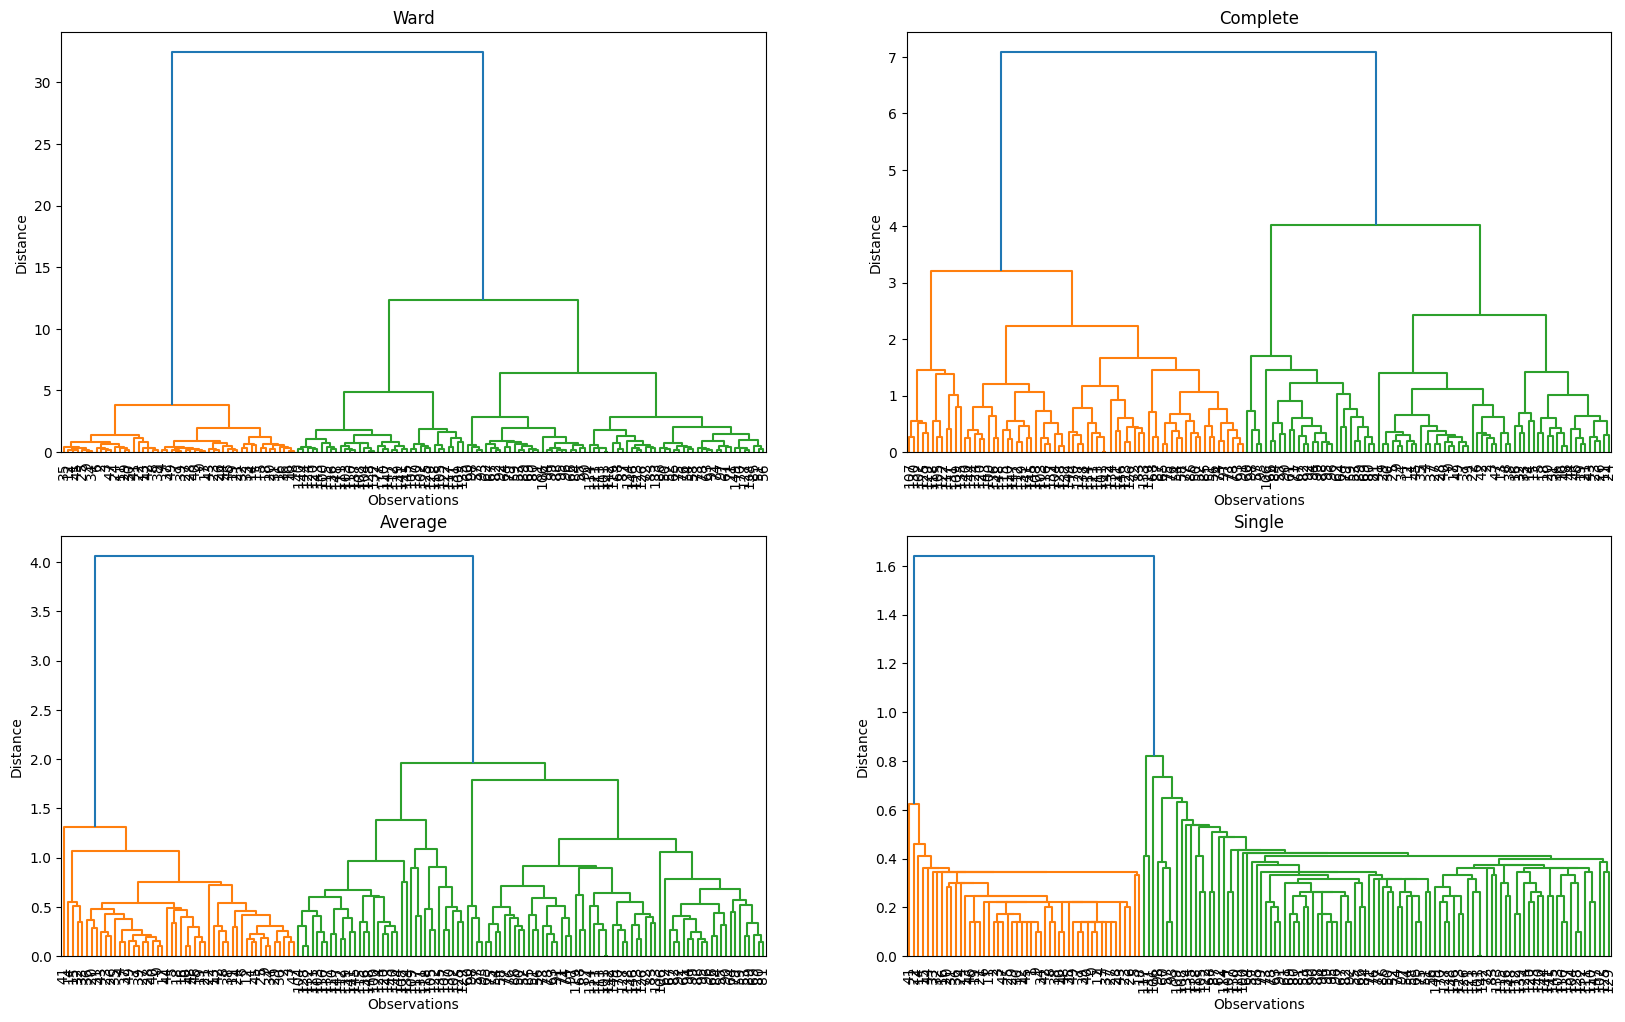

In [16]:
# butun metotlara gore dendrogram çizimi 

plt.figure(figsize = (20,12))

plt.subplot(221)
plt.title("Ward")
plt.xlabel("Observations")
plt.ylabel("Distance")
dendrogram(hc_ward, leaf_font_size = 10)

plt.subplot(222)
plt.title("Complete")
plt.xlabel("Observations")
plt.ylabel("Distance")
dendrogram(hc_complete, leaf_font_size = 10)

plt.subplot(223)
plt.title("Average")
plt.xlabel("Observations")
plt.ylabel("Distance")
dendrogram(hc_average, leaf_font_size = 10)

plt.subplot(224)
plt.title("Single")
plt.xlabel("Observations")
plt.ylabel("Distance")
dendrogram(hc_single, leaf_font_size = 10);

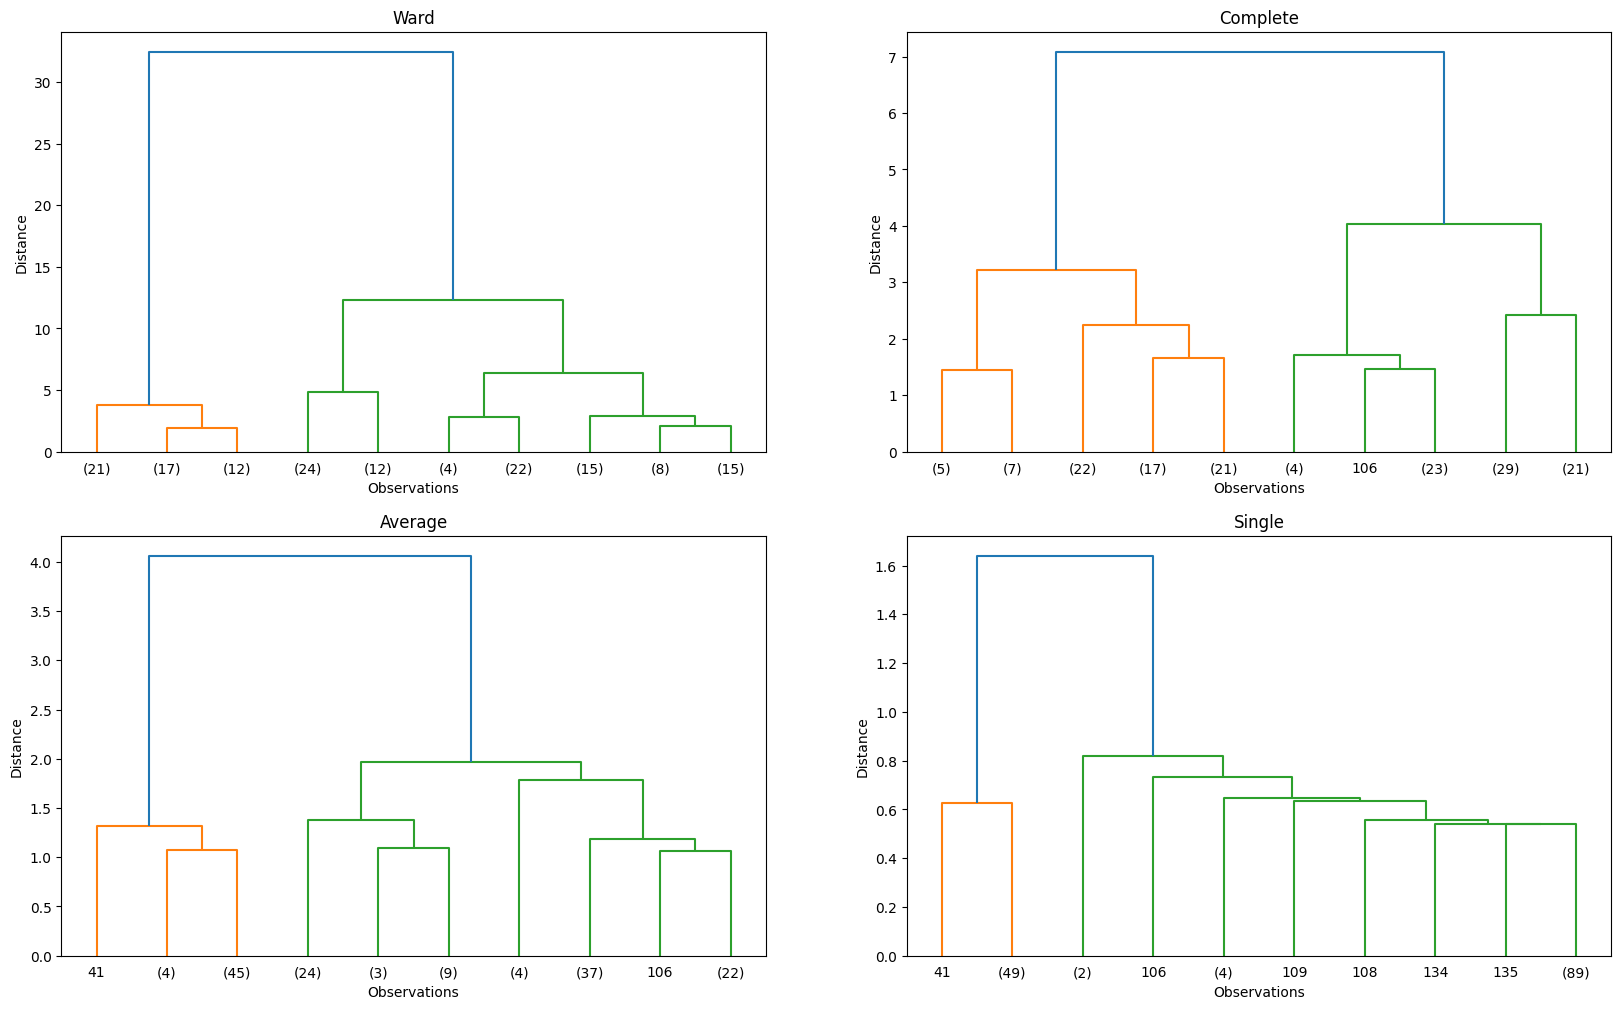

In [17]:
# grafiklerin gorunumunu sadeleştirleim

plt.figure(figsize = (20,12))

plt.subplot(221)
plt.title("Ward")
plt.xlabel("Observations")
plt.ylabel("Distance")
dendrogram(hc_ward, leaf_font_size = 10, truncate_mode='lastp', p=10)

plt.subplot(222)
plt.title("Complete")
plt.xlabel("Observations")
plt.ylabel("Distance")
dendrogram(hc_complete, leaf_font_size = 10, truncate_mode='lastp', p=10)

plt.subplot(223)
plt.title("Average")
plt.xlabel("Observations")
plt.ylabel("Distance")
dendrogram(hc_average, leaf_font_size = 10, truncate_mode='lastp', p=10)

plt.subplot(224)
plt.title("Single")
plt.xlabel("Observations")
plt.ylabel("Distance")
dendrogram(hc_single, leaf_font_size = 10, truncate_mode='lastp' , p=10);  # p en son dllarda oluşacak küme sayısı

## Hierarchical Clustering (Agglomerative)

In [12]:
from sklearn.cluster import AgglomerativeClustering

NOT: yukardaki dendrogramlarda bize 2 cluster önerilmesine rağmen uzman görüşü bize 3 dediği için cluster sayısını 3 alarak devam edeceğiz

AgglomerativeClustering sınıfının bazı önemli özellikleri:

Birleştirme Stratejisi: Birleştirici hiyerarşik kümeleme, başlangıçta her veri noktasını ayrı bir küme olarak ele alır ve adım adım en benzer iki kümeyi birleştirerek devam eder. Bu işlem, belirli bir küme sayısına ulaşana kadar veya başka bir durdurma kriteri karşılanana kadar devam eder.

Uzaklık Ölçütü: AgglomerativeClustering, kümeler arasındaki benzerliği veya uzaklığı ölçmek için çeşitli stratejiler kullanır. Bunlar arasında 'ward', 'complete', 'average', 'single' gibi birleştirme yöntemleri bulunur. Her yöntem, kümeleri birleştirirken farklı bir uzaklık ölçütü kullanır.

### Silhouette Score

In [13]:
from sklearn.metrics import silhouette_score

Cluster sayısını vermeden önce 2-10 arasını siluet skoru olarak denyelim. Cluster metodu olarak **Agglomerative Clustering** kullanılacak
Silhouette değeri -1 ile 1 arasında değişir:

**s = (b-a) / max(a,b)**

**a = cluster içindeki gözlemler arası mesafeler**

**b = iki cluster arasındaki mesafe en yakın iki culster diyebiliriz**

In [14]:
K= range (2,10)
for k in K:
    model =AgglomerativeClustering(n_clusters = k)
    model.fit_predict(X)
    print("f'Silhouette Score for",{k}, "clusters",{silhouette_score(X, model.labels_)})

f'Silhouette Score for {2} clusters {0.6867350732769781}
f'Silhouette Score for {3} clusters {0.5543236611296426}
f'Silhouette Score for {4} clusters {0.48896708575546993}
f'Silhouette Score for {5} clusters {0.48438258927906036}
f'Silhouette Score for {6} clusters {0.359237619260309}
f'Silhouette Score for {7} clusters {0.34220719366205077}
f'Silhouette Score for {8} clusters {0.3435906599119544}
f'Silhouette Score for {9} clusters {0.3304886352874667}


NOT: silhouet skorunda en iyi değeri 2 vermiş olmasına rağmen uzman görüşü 3 dediği için bu şekilde devam edebilirim. bununla beraber 3 için silhouette skoru da 0.50 nin üzerinde olduğu için alınabilir

Cluster sayısını 3 olacak şekilde karar vererek işlemlere devam ediyoruz.

In [17]:
model1 =  AgglomerativeClustering(n_clusters=3,linkage = "ward") 
model1.fit_predict(X)

# Kmeans den farklı olarak buradda sadece "fit_predict" yapılır

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 2, 2, 2, 0, 2, 2, 2,
       2, 2, 2, 0, 0, 2, 2, 2, 2, 0, 2, 0, 2, 0, 2, 2, 0, 0, 2, 2, 2, 2,
       2, 0, 0, 2, 2, 2, 0, 2, 2, 2, 0, 2, 2, 2, 0, 2, 2, 0], dtype=int64)

In [18]:
# alttaki değerler Agglomerative Clusterng tekniğiyle elde ettiğimiz küme atamalarıdır
model1.labels_

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 2, 2, 2, 0, 2, 2, 2,
       2, 2, 2, 0, 0, 2, 2, 2, 2, 0, 2, 0, 2, 0, 2, 2, 0, 0, 2, 2, 2, 2,
       2, 0, 0, 2, 2, 2, 0, 2, 2, 2, 0, 2, 2, 2, 0, 2, 2, 0], dtype=int64)

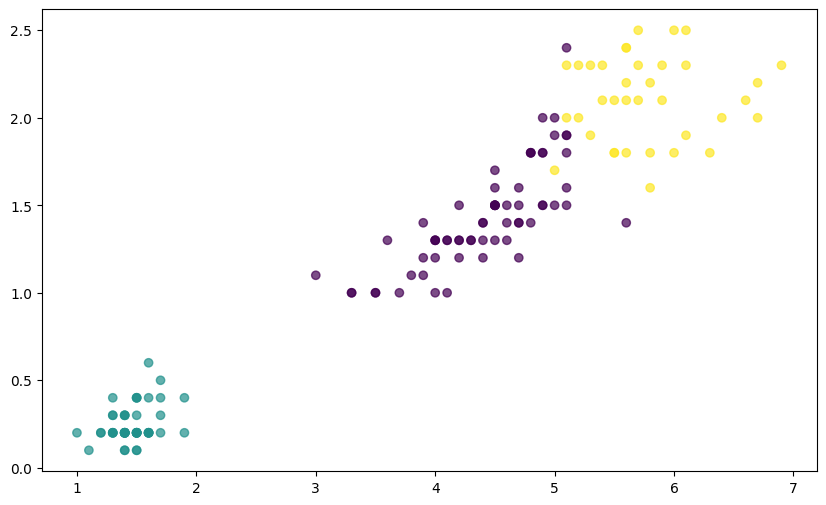

In [19]:
# kumelere yeni atanan gozlemlerin çizimini gorelim (gerçek degerlere gore çizilmedi !!)

plt.scatter(X["petal_length"], X["petal_width"], c= model1.labels_, cmap= "viridis", alpha = 0.7);


In [20]:
clusters = model1.labels_    #model tahminlerimizi atadık

In [21]:
df["predicted_clusters"] = clusters    #orjinal data setine atadık
df.head()

,sepal_length,sepal_width,petal_length,petal_width,predicted_clusters
0,5.1,3.5,1.4,0.2,1
1,4.9,3.0,1.4,0.2,1
2,4.7,3.2,1.3,0.2,1
3,4.6,3.1,1.5,0.2,1
4,5.0,3.6,1.4,0.2,1


In [22]:
odf = pd.read_csv("iris.csv")
labels=pd.DataFrame(odf["species"]) # uzmandan gelen label
labels

,species
0,setosa
1,setosa
2,setosa
3,setosa
4,setosa
...,...
145,virginica
146,virginica
147,virginica
148,virginica


In [23]:
X["predict_clusters"] =clusters
X["labels"]= labels
X

# altta hem predict olanlar hem de uzman görüşü sonrası gelen labels lar aynı data frame de..

,sepal_length,sepal_width,petal_length,petal_width,predict_clusters,labels
0,5.1,3.5,1.4,0.2,1,setosa
1,4.9,3.0,1.4,0.2,1,setosa
2,4.7,3.2,1.3,0.2,1,setosa
3,4.6,3.1,1.5,0.2,1,setosa
4,5.0,3.6,1.4,0.2,1,setosa
...,...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,2,virginica
146,6.3,2.5,5.0,1.9,0,virginica
147,6.5,3.0,5.2,2.0,2,virginica
148,6.2,3.4,5.4,2.3,2,virginica


In [24]:
# cross table (crosstab) ile karşılaştırma yapalım

ct = pd.crosstab(X["predict_clusters"], X["labels"])
ct

labels,setosa,versicolor,virginica
predict_clusters,,,
0,0,49,15
1,50,0,0
2,0,1,35


In [ ]:
# 0. labels 49 doğru tahmin ama 15 fazladan tahmin etmiş onlarda yanlış 
# 1.    ''   50  ''     ''
#2.      ''  35  ''     ''   1 yanlış tahmin 14 ünü bilememiş 

#  Toplam 15+1 = 16 hatalı sonuç var

## ARI Score

Adjusted Rand Index (ARI), iki kümelemenin benzerliğini ölçer ve bu benzerliği -1 ile 1 arasında bir değerle ifade eder.

In [26]:
from sklearn.metrics.cluster import adjusted_rand_score

In [27]:
adjusted_rand_score(X.labels, X.predict_clusters) #gerçek ve predicted degerler yazılır. burada string ile sayısalı karşılaştırabiliyor

0.7311985567707746

## Visualization Clusters

gerçek ve predict değerleri görselleştirerek karşılaştıralım

In [28]:
# kategorik verileri, analiz için uygun olan sayısal verilere çevirmek amacıyla kullanılır

X_labels = X.labels.map({"versicolor":0, "setosa":1,"virginica":2})
X_labels

0      1
1      1
2      1
3      1
4      1
      ..
145    2
146    2
147    2
148    2
149    2
Name: labels, Length: 150, dtype: int64

alttaki 2 grafikte uzman görüşü (actual) ve predicted olan bizim küme tahminlerini karşılaştırma yapacağız

ilk grfaik sepal length ve sepal width e göre çizildi

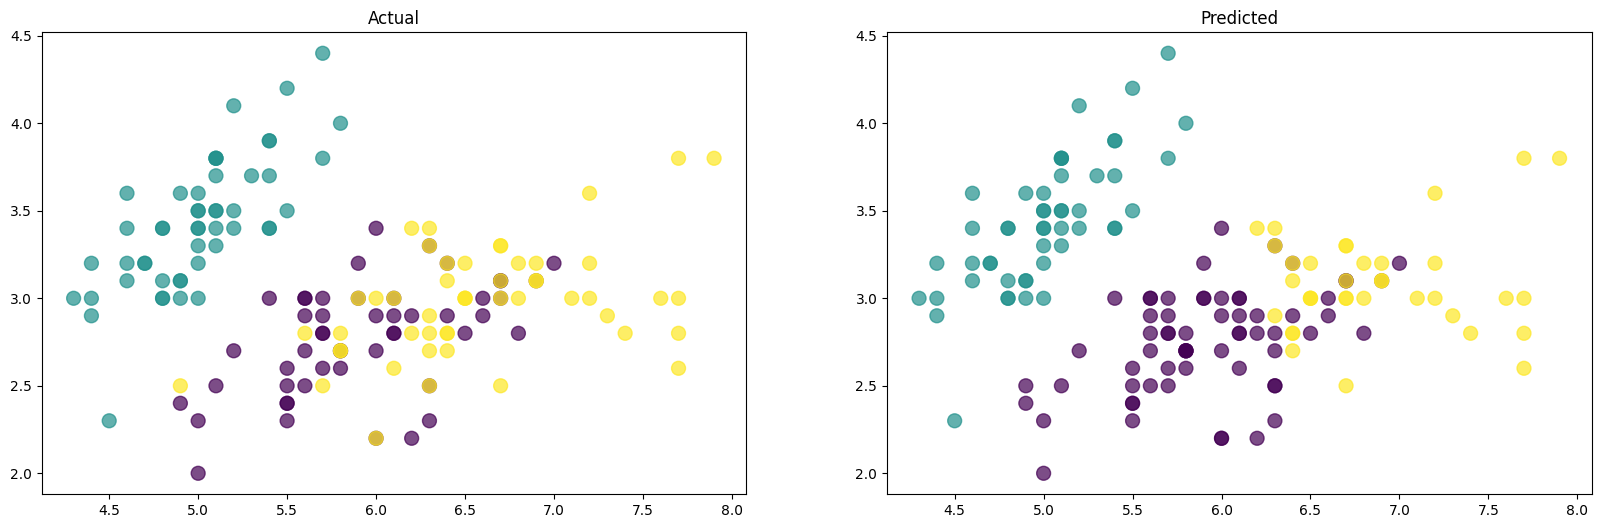

In [29]:
plt.figure(figsize = (20,6))

plt.subplot(121)
plt.scatter(X["sepal_length"], X["sepal_width"], c = X_labels, cmap = "viridis", alpha=0.7, s=100)
plt.title("Actual")

plt.subplot(122)
plt.scatter(X["sepal_length"], X["sepal_width"], c = X.predict_clusters, cmap = "viridis", alpha=0.7, s=100)
plt.title("Predicted");

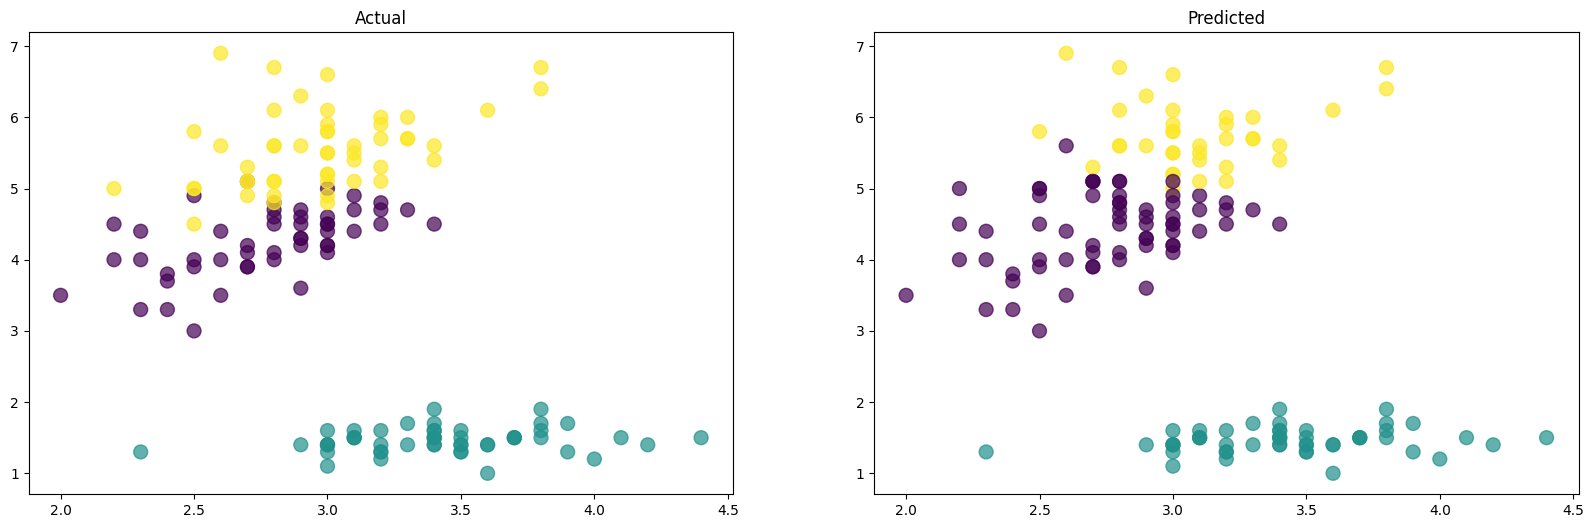

In [30]:
plt.figure(figsize = (20,6))

plt.subplot(121)
plt.scatter(X["sepal_width"], X["petal_length"], c = X_labels, cmap = "viridis", alpha=0.7, s=100)
plt.title("Actual")

plt.subplot(122)
plt.scatter(X["sepal_width"], X["petal_length"], c = X.predict_clusters, cmap = "viridis", alpha=0.7, s=100)
plt.title("Predicted");

## Remodeling according to discriminating features

modeli, burada yeniden kurmaya başlayalım



In [31]:
X.head()

,sepal_length,sepal_width,petal_length,petal_width,predict_clusters,labels
0,5.1,3.5,1.4,0.2,1,setosa
1,4.9,3.0,1.4,0.2,1,setosa
2,4.7,3.2,1.3,0.2,1,setosa
3,4.6,3.1,1.5,0.2,1,setosa
4,5.0,3.6,1.4,0.2,1,setosa


In [32]:
# groupby iler feature ların ortalama değerlerini üretelim

clus_pred = X.iloc[:, [0, 1, 2, 3, 5]].groupby("labels").mean().T
clus_pred

labels,setosa,versicolor,virginica
sepal_length,5.006,5.936,6.588
sepal_width,3.428,2.770,2.974
petal_length,1.462,4.260,5.552
petal_width,0.246,1.326,2.026


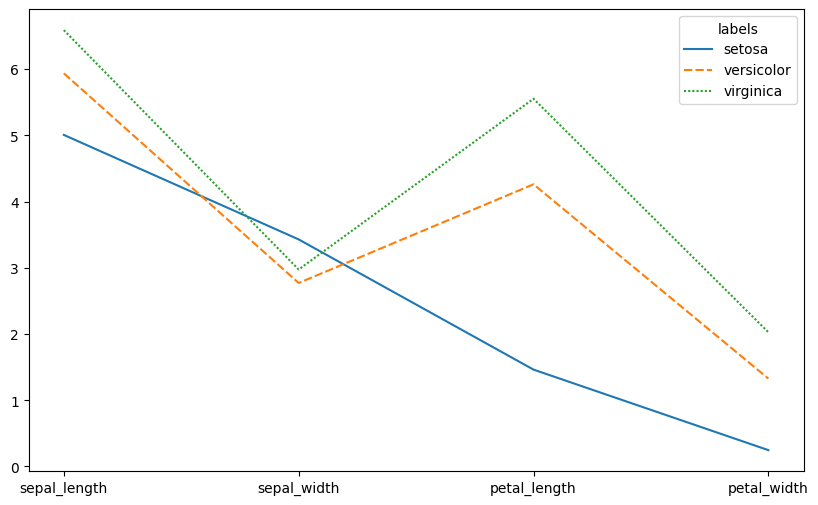

In [33]:
sns.lineplot(data = clus_pred);

**SONUÇ CÜMLESİ**: petal lenght ve petal width in modelde seçilmesi gereken 2 feature olduğunu gördüm. 

AMa buradaki seçimi destekleyecek veya etkilyecek bir metot olarak Box Plot çizimini görelim

<Axes: xlabel='labels', ylabel='petal_width'>

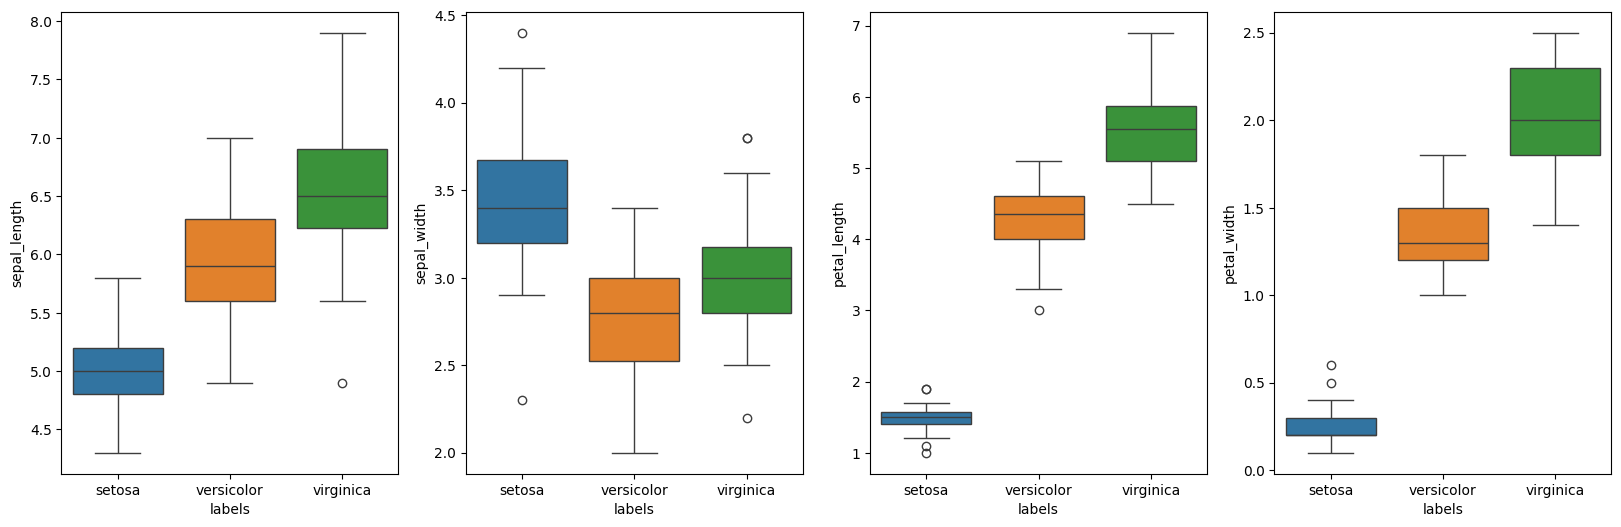

In [36]:
# BOX Plot çizimi

plt.figure(figsize = (20,6))
plt.subplot(141)
sns.boxplot(y = "sepal_length", x = "labels", data = X, palette="tab10")
plt.subplot(142)
sns.boxplot(y = "sepal_width", x = "labels", data = X, palette="tab10")
plt.subplot(143)
sns.boxplot(y = "petal_length", x = "labels", data = X, palette="tab10")
plt.subplot(144)
sns.boxplot(y = "petal_width", x = "labels", data = X, palette="tab10")

sağdaki 2 adet box plot çiziminde birbirinden gayet iyi ayrıştığı görülüyor.yukardaki bulguları destekliyor

Setosa üçünde de tamamen ayrılmış
2. grafikte versicoloe ve virginica da yoğun birbirine girmiş
3. grafik ve 4. grafik en iyi ayrışmayı sağlamış

bundan sonra yolumuza 2 feature ile devam edeceğiz


### Dendrogram

In [37]:
X2 = X.iloc[:, [2,3]]
X2

,petal_length,petal_width
0,1.4,0.2
1,1.4,0.2
2,1.3,0.2
3,1.5,0.2
4,1.4,0.2
...,...,...
145,5.2,2.3
146,5.0,1.9
147,5.2,2.0
148,5.4,2.3


**NOT**:burada ilave olaak Hopkins e de bakaiblirdik. onun da düşmüş olacağını yine görecektik, tekrar buraya almadım.

In [38]:
hc_ward = linkage(y = X2, method = "ward") # X2  seti için 'ward' yöntemiyle birleştirici hiyerarşik kümeleme gerçekleştirir.
hc_complete = linkage(X2, "complete")  # complete' veya 'maksimum' yöntemini kullanır
hc_average = linkage(X2, "average")  # tüm çiftler arasındaki ortalama uzaklığı kullanarak kümeleri birleştirir
hc_single = linkage(X2, "single")  # Single' veya 'minimum' yöntemi, kümeler arasındaki en yakın noktaları dikkate alı

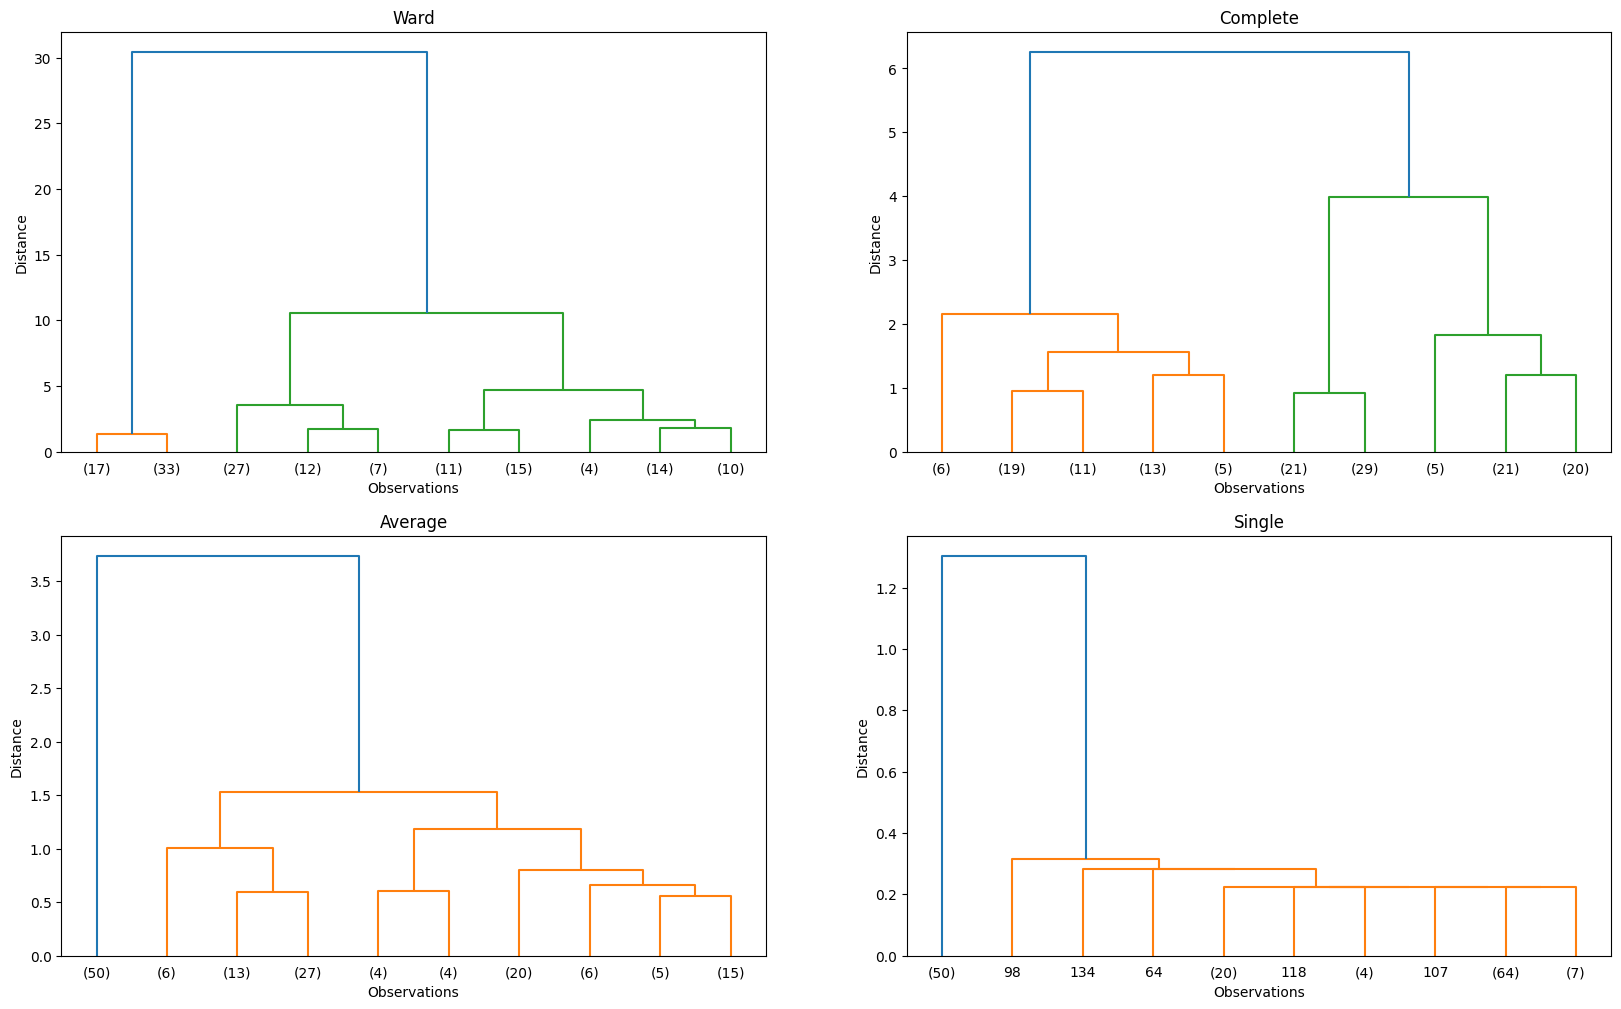

In [39]:
plt.figure(figsize = (20,12))

plt.subplot(221)
plt.title("Ward")
plt.xlabel("Observations")
plt.ylabel("Distance")
dendrogram(hc_ward, leaf_font_size = 10, truncate_mode='lastp', p=10)

plt.subplot(222)
plt.title("Complete")
plt.xlabel("Observations")
plt.ylabel("Distance")
dendrogram(hc_complete, leaf_font_size = 10, truncate_mode='lastp', p=10)

plt.subplot(223)
plt.title("Average")
plt.xlabel("Observations")
plt.ylabel("Distance")
dendrogram(hc_average, leaf_font_size = 10, truncate_mode='lastp', p=10)

plt.subplot(224)
plt.title("Single")
plt.xlabel("Observations")
plt.ylabel("Distance")
dendrogram(hc_single, leaf_font_size = 10, truncate_mode='lastp', p=10);

### S(Silhouette) Score

In [40]:
K = range(2,10)

for k in K:
    model = AgglomerativeClustering(n_clusters = k)
    model.fit_predict(X2)
    print(f'Silhouette Score for {k} clusters: {silhouette_score(X2, model.labels_)}')

Silhouette Score for 2 clusters: 0.7669465622770762
Silhouette Score for 3 clusters: 0.6573949269287823
Silhouette Score for 4 clusters: 0.5895284480910935
Silhouette Score for 5 clusters: 0.5781917218437669
Silhouette Score for 6 clusters: 0.5747380906148477
Silhouette Score for 7 clusters: 0.5830818097709548
Silhouette Score for 8 clusters: 0.5678904784921739
Silhouette Score for 9 clusters: 0.5469910001848306


silhouette_score için öncekine göre iyileşme var

## Final model

In [42]:
final_model = AgglomerativeClustering(n_clusters=3, linkage = "complete")
clusters = final_model.fit_predict(X2)

In [43]:
X2["predicted_clusters"] = clusters
X2["labels"] = labels
X2

,petal_length,petal_width,predicted_clusters,labels
0,1.4,0.2,2,setosa
1,1.4,0.2,2,setosa
2,1.3,0.2,2,setosa
3,1.5,0.2,2,setosa
4,1.4,0.2,2,setosa
...,...,...,...,...
145,5.2,2.3,0,virginica
146,5.0,1.9,0,virginica
147,5.2,2.0,0,virginica
148,5.4,2.3,0,virginica


In [44]:
X2_ct = pd.crosstab(X2["predicted_clusters"], X2["labels"])
X2_ct

# yeni durumu gosteriyor..  6 tane hata var

labels,setosa,versicolor,virginica
predicted_clusters,,,
0,0,5,49
1,0,45,1
2,50,0,0


In [45]:
ct   # alttaki tablo  daha önceki degerleri gösteriyor.. 16 hatalı kumeleme

labels,setosa,versicolor,virginica
predict_clusters,,,
0,0,49,15
1,50,0,0
2,0,1,35


orjinal ve yeni clusterlama karşılaştırmasını gorsel olarak aşağıda yeniden yapalım

In [46]:
X2_labels = X2.labels.map({"versicolor":0, "setosa":1,"virginica":2})
X2_labels

0      1
1      1
2      1
3      1
4      1
      ..
145    2
146    2
147    2
148    2
149    2
Name: labels, Length: 150, dtype: int64

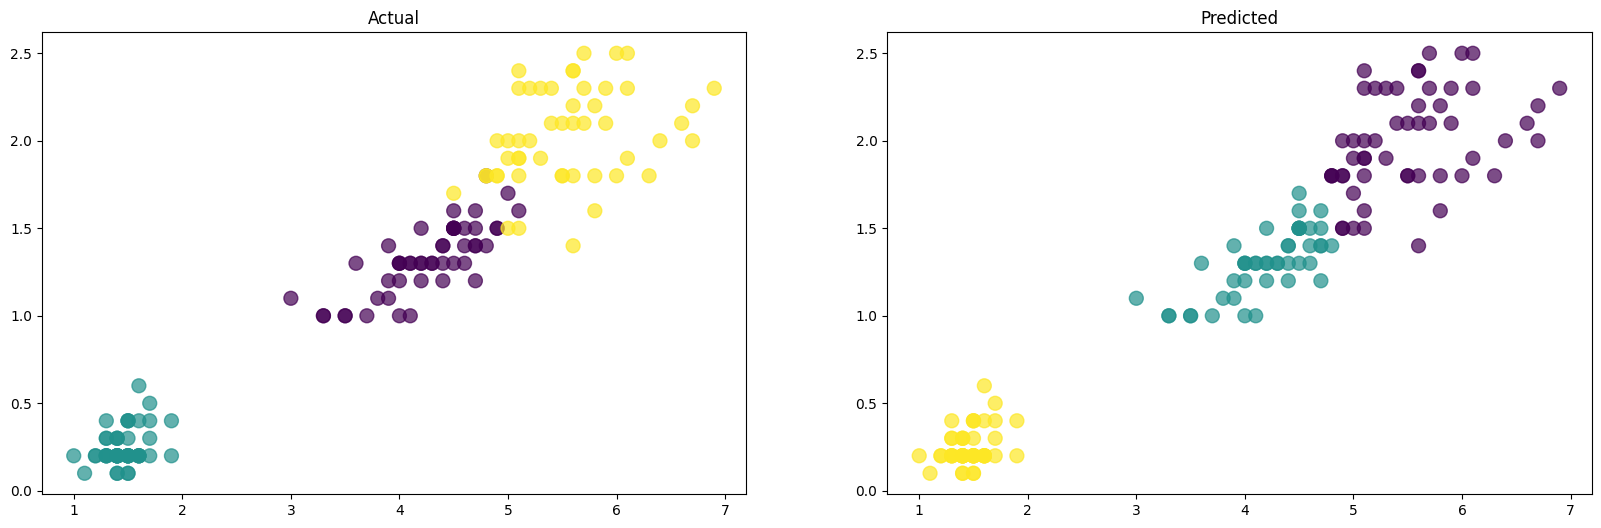

In [47]:
plt.figure(figsize = (20,6))

plt.subplot(121)
plt.scatter(X2["petal_length"], X2["petal_width"], c = X2_labels, cmap = "viridis", alpha=0.7, s=100)
plt.title("Actual")

plt.subplot(122)
plt.scatter(X2["petal_length"], X2["petal_width"], c = X2.predicted_clusters, cmap = "viridis", alpha=0.7, s=100)
plt.title("Predicted");

### ARI Score

In [48]:
adjusted_rand_score(X2.labels, X2.predicted_clusters)

0.8857921001989628

## Prediction cluster of new data

In [49]:
new_data = [[1.7, 0.2], [2.3, 0.5]]

In [50]:
final_model.predict(new_data)

AttributeError: 'AgglomerativeClustering' object has no attribute 'predict'

Agglomerative de predict fonksiyonu yok

tahmin yapmak için df in altına bu iki yeni satırı ekleyip komple yeni df i tekrar modele sokmak gerekiyor
YENİ DATA GELİNCE DATAYA YENİ SATIR OLARAK EKLEYİP YENİDEN MODEL KURACAĞIZ

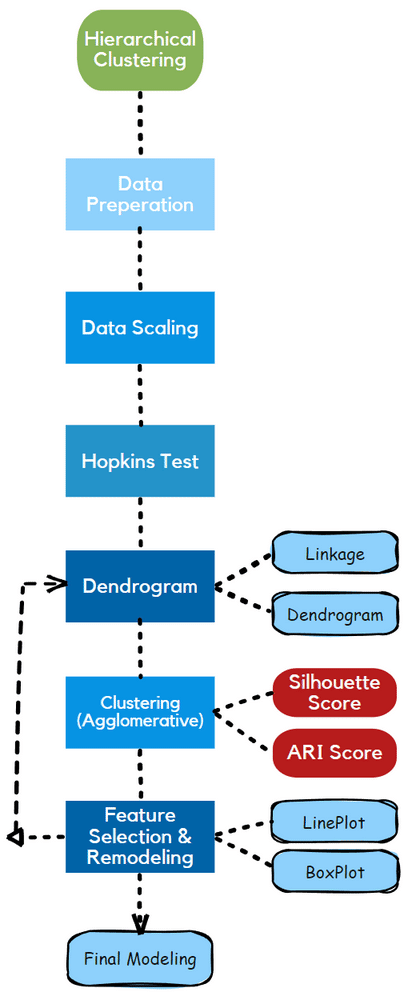